## Hysteresis and regression analysis example

Given a calibration of an instrument for an increasing and decreasing input $q_i$ [kPa] and output of the instrument $q_o$ [kPa]

In [4]:
%pylab inline
pylab.rcParams['figure.figsize'] = 10, 8 
pylab.rcParams['font.size'] = 14 

Populating the interactive namespace from numpy and matplotlib


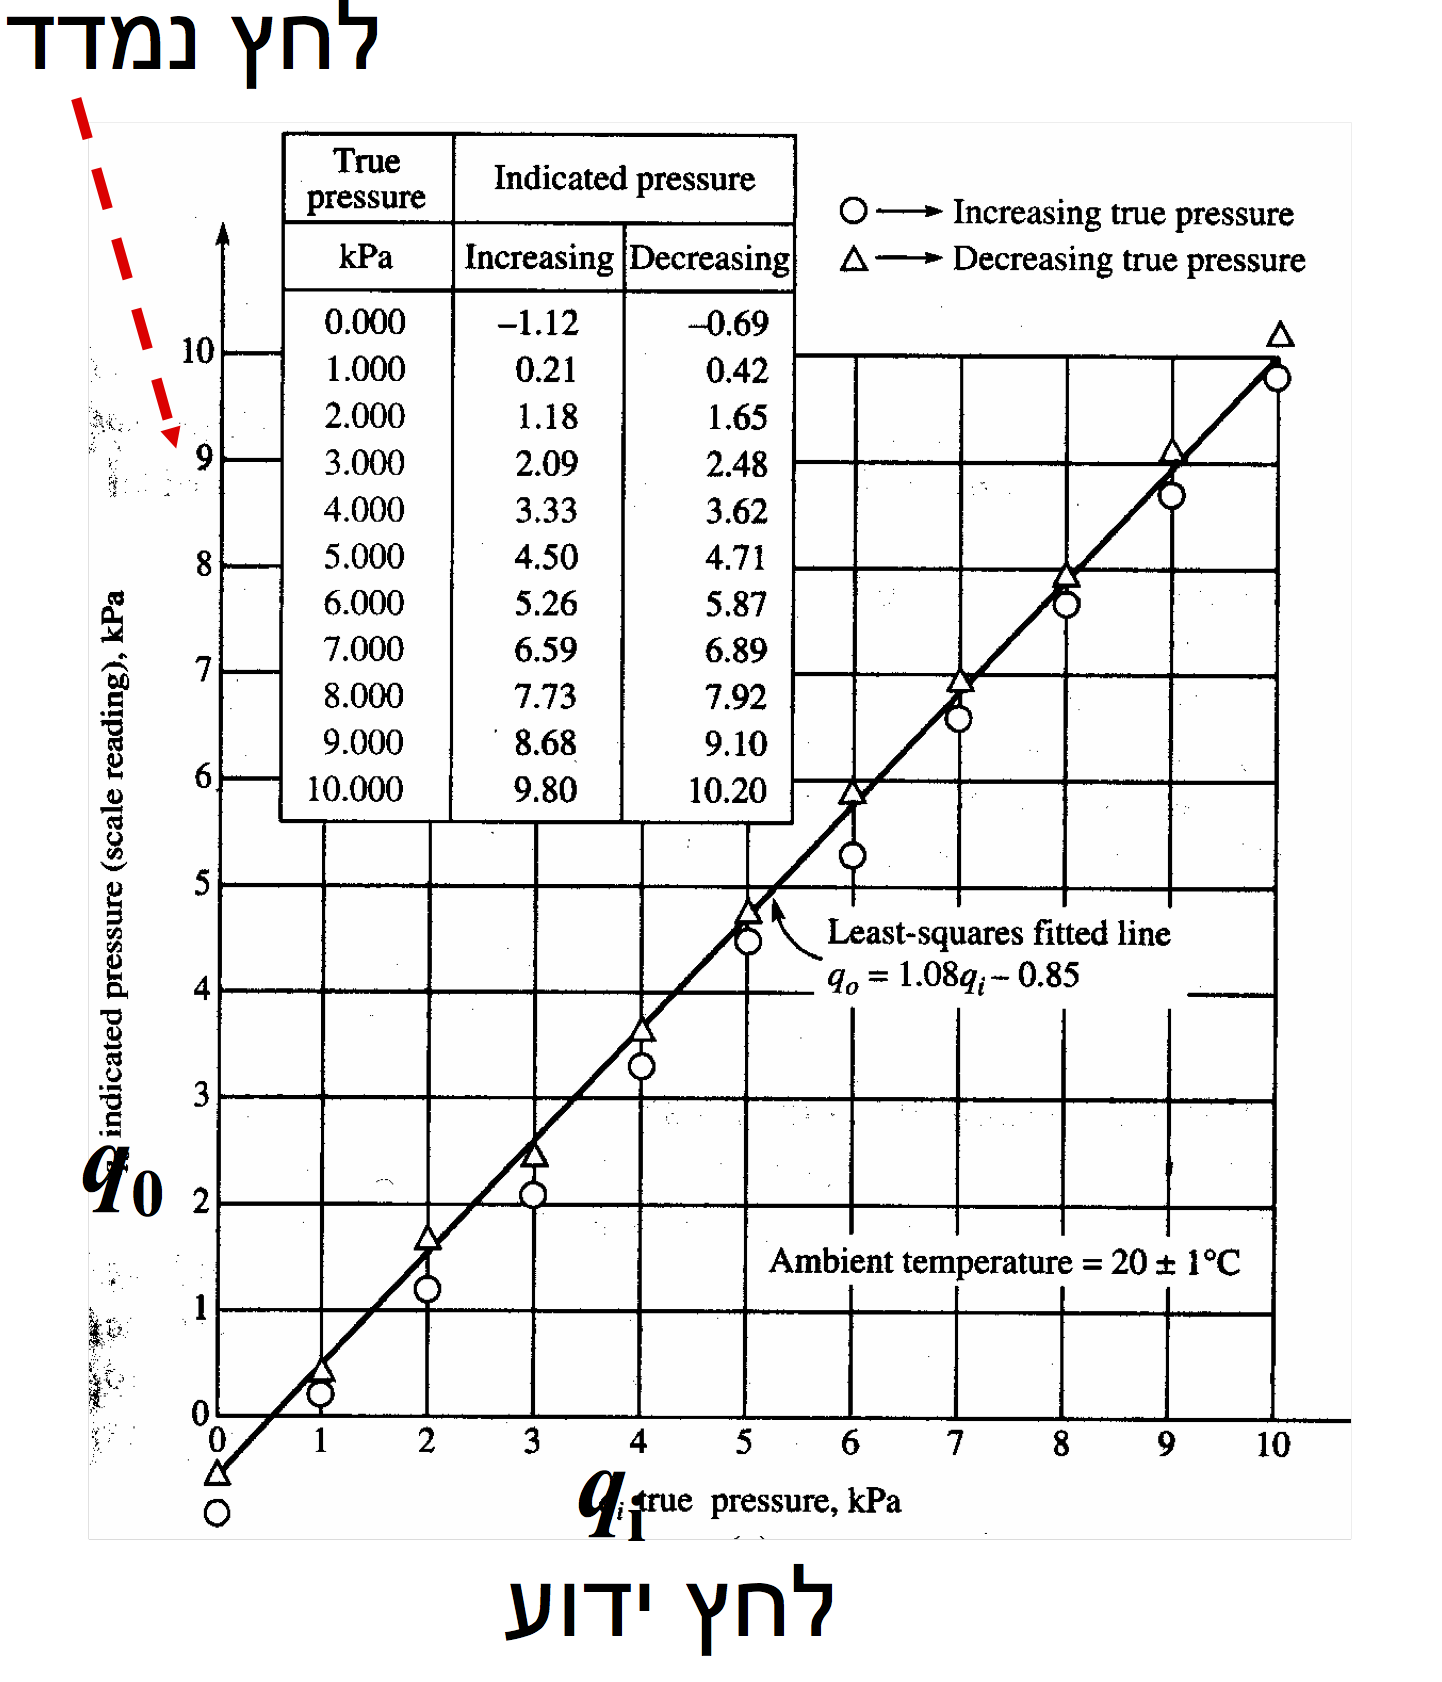

In [5]:
from IPython.core.display import Image 
Image(filename='img/pressure_calibration_example.png',width=400)

In [6]:
# increasing
xi = array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
yi = array([-1.12, 0.21, 1.18, 2.09, 3.33, 4.50, 5.26, 6.59, 7.73, 8.68, 9.80])
# decreasing
xd = xi.copy()
yd = array([-0.69, 0.42, 1.65, 2.48, 3.62, 4.71, 5.87, 6.89, 7.92, 9.10, 10.20])

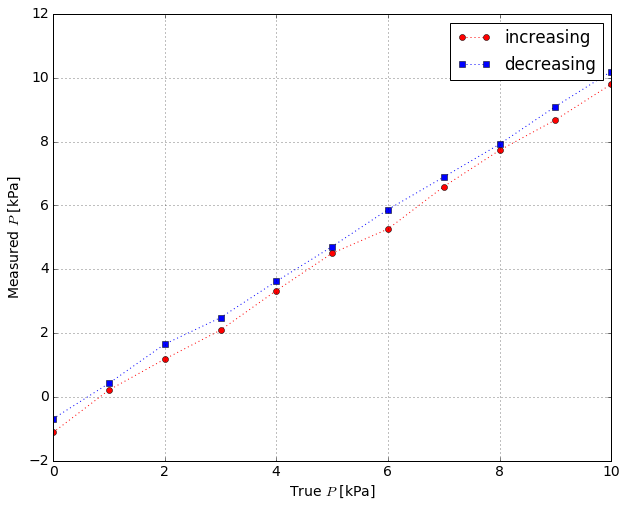

In [7]:
figure()
plot(xi,yi,'r:o',xd,yd,'b:s')
grid('on')
xlabel('True $P$ [kPa]')
ylabel('Measured $P$ [kPa]')
legend(('increasing','decreasing'))


### Estimate the hysteresis error:

$e_h = y_{up} - y_{down}$

$e_{h_{max}} = max(|e_h|)$

$e_{h_{max}}\% = 100\% \cdot \frac{e_{h_{max}}}{y_{max}-y_{min}} $

In [8]:
e_h = yi-yd 
print "e_h =", e_h,"[kPa]"

e_h = [-0.43 -0.21 -0.47 -0.39 -0.29 -0.21 -0.61 -0.3  -0.19 -0.42 -0.4 ] [kPa]


In [9]:
e_hmax = np.max(np.abs(e_h))
print "e_hmax= %3.2f %s" % (e_hmax,"[kPa]")

e_hmax= 0.61 [kPa]


In [10]:
e_hmax_p = 100*e_hmax/(np.max(xi) - np.min(xd))
print "Relative error = %3.2f%s FSO" % (e_hmax_p,"%")

Relative error = 6.10% FSO


## Regression analysis
Following the recipe of http://www.answermysearches.com/how-to-do-a-simple-linear-regression-in-python/124/

In [11]:
def linreg(X, Y):
    """
    Summary
        Linear regression of y = ax + b
    Usage
        real, real, real = linreg(list, list)
    Returns coefficients to the regression line "y=ax+b" from x[] and y[], and R^2 Value
    """
    if len(X) != len(Y):  raise ValueError, 'unequal length'
    N = len(X)
    Sx = Sy = Sxx = Syy = Sxy = 0.0
    for x, y in map(None, X, Y):
        Sx = Sx + x
        Sy = Sy + y
        Sxx = Sxx + x*x
        Syy = Syy + y*y
        Sxy = Sxy + x*y
    det = Sxx * N - Sx * Sx
    a, b = (Sxy * N - Sy * Sx)/det, (Sxx * Sy - Sx * Sxy)/det
    meanerror = residual = 0.0
    for x, y in map(None, X, Y):
        meanerror = meanerror + (y - Sy/N)**2
        residual = residual + (y - a * x - b)**2
    RR = 1 - residual/meanerror
    ss = residual / (N-2)
    Var_a, Var_b = ss * N / det, ss * Sxx / det
    #print "y=ax+b"
    #print "N= %d" % N
    #print "a= %g \\pm t_{%d;\\alpha/2} %g" % (a, N-2, sqrt(Var_a))
    #print "b= %g \\pm t_{%d;\\alpha/2} %g" % (b, N-2, sqrt(Var_b))
    #print "R^2= %g" % RR
    #print "s^2= %g" % ss
    return a, b, RR

In [12]:
print "Increasing"
ai,bi,Ri = linreg(xi,yi)
print ai,bi,Ri
print "Decreasing"
ad,bd,Rd = linreg(xd,yd)
print ad,bd,Rd

Increasing
1.08236363636 -1.02545454545 0.999064710893
Decreasing
1.08227272727 -0.668636363636 0.999638066886


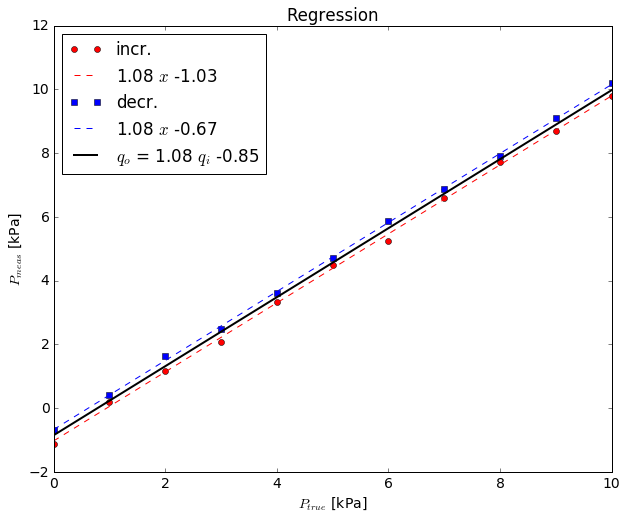

In [13]:
figure()
plot(xi,yi,'ro',xi,xi*ai+bi,'r--',xd,yd,'bs',xd,xd*ad+bd,'b--')
xlabel('$P_{true}$ [kPa]')
ylabel('$P_{meas}$ [kPa]')
title('Regression')
leg1 = '%3.2f $x$ %3.2f' % (ai,bi)
leg2 = '%3.2f $x$ %3.2f' % (ad,bd)
legend(('incr.',leg1,'decr.',leg2),loc='best')

# all all together:
a,b,R = linreg(r_[xi,xd],r_[yi,yd])
hold(True)
plot(xi,xi*a+b,'k-',lw=2)
leg3 = '$q_o$ = %3.2f $q_i$ %3.2f' % (a,b)
legend(('incr.',leg1,'decr.',leg2,leg3),loc='best')

$$q_0 = m q_i + b$$

$$q_0 = 1.8 q_i - 0.85$$

$$\sigma_m^2 = \frac{N \sigma_{q_0}^2}{N\sum q_i^2 - \left(\sum q_i \right)^2}$$

$$\sigma_b^2 = \frac{\sigma_{q_0}^2\sum q_i^2}{N\sum q_i^2 - \left(\sum q_i \right)^2}$$

$$\sigma_{q_0}^2 = \frac{1}{N}\sum\left(m\,q_i + b - q_0 \right)^2 $$

$$\sigma_{q_i}^2 = \frac{1}{N}\sum\left( \frac{q_0 - b}{m} - q_i \right)^2 = \frac{\sigma_{q_0}^2}{m^2} $$


In [14]:
def regression_analysis(qi,qo):
    m,b,R = linreg(qi,qo)
    # print 'qo = %3.2f qi %3.2f' % (m,b)
    N = size(qi)
    d = m*qi + b - qo # deviation
    Sqo = sum(d**2)/N
    Sqi = Sqo/m**2
    Sm = N*Sqo/(N*sum(qi**2) - sum(qi)**2)
    Sb = Sqo*sum(qi**2)/(N*sum(qi**2) - sum(qi)**2)
    return Sm,Sb,Sqi,Sqo


In [15]:
qi = r_[xi,xd]
qo = r_[yi,yd]

print qi
print qo

Sm,Sb,Sqi,Sqo = regression_analysis(qi,qo)
print 'Sm, Sb, Sqi, Sqo = '
print '%6.4f, %6.4f %6.4f %6.4f' % (Sm,Sb,Sqi,Sqo)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]
[ -1.12   0.21   1.18   2.09   3.33   4.5    5.26   6.59   7.73   8.68
   9.8   -0.69   0.42   1.65   2.48   3.62   4.71   5.87   6.89   7.92
   9.1   10.2 ]
Sm, Sb, Sqi, Sqo = 
0.0002, 0.0063 0.0336 0.0394


Taking $3 \sigma$ for $99.7\%$ certainty level:

$m = 1.08 \pm 0.0006$

$b = -0.85 \pm 0.018$

When we use calibration curve for the measurement:
    
$q_i = (q_o + 0.85)/1.08 = 0.9233 q_0 + 0.785$

$S_{q_i}^2 = 0.034$

If we measured for instance 4.32 kPa, we transfer it to 4.79 kPa and write:

(4.32*0.85)/1.08 = 4.787
    
### The final result is    
$P = 4.79 \pm 0.102$ kPa (99.7\%)